# Projet StatApp

## Imports et requirements

In [1]:
from datasets import load_dataset
import pickle
import pandas as pd
import sys
import io
import re
import statistics as stats
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


C:\Users\trema\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Forcer l'encodage en UTF-8 pour les caractères de l'alphabet grec.

In [3]:
# TODO problème à résoudre

Stocker la BDD.

In [4]:
# ds = load_dataset("TEAMREBOOTT-AI/SciCap-MLBCAP")

Sauvegarder le dataset dans un fichier pickle

In [5]:
# with open("dataset.pkl", "wb") as f:
#     pickle.dump(ds, f)

Une fois cela fait, on ne travaille qu'à partir du dataset directement importé.

In [3]:
with open("dataset.pkl", "rb") as f:
    ds = pickle.load(f)

data = ds["train"]
print(data)

Dataset({
    features: ['image', 'id', 'figure_type', 'ocr', 'paragraph', 'mention', 'figure_description', 'mlbcap_long', 'mlbcap_short', 'categories'],
    num_rows: 47639
})


Il y a **47 639** observations.

Chargeons les données dans l'environnement.

In [ ]:
# Récupérer l'image depuis l'ensemble de données


Regardons de plus près une observation.

In [8]:
for k in data[0]:
    print(f"{k} : {data[0][k]}")
    print('-'*10)

image = data[0]["image"]
image.show()

image : <PIL.PngImagePlugin.PngImageFile image mode=RGB size=467x397 at 0x1B72EC8D6D0>
----------
id : 511159285
----------
figure_type : Graph Plot
----------
ocr : ["0.009_", "DMnF", "DoMi", "Om "]
----------
paragraph : ["Initially, the 32 atoms stay at their equilibrium position. We set the initial velocity so that the left-most atom has a large velocity towards right and other atoms have equal velocity towards left. The mean velocity is equal to 0, so the center of mass does not move. Fig. 8 shows the trajectory of positions of the first three atom from the left. We observe that the results from TRBOMD agree very well with the BOMD results with convergent SCF iterations. Let us note that in the simulation, the left-most atom crosses over the second left-most atom. This happens since in our model, we have taken a 1D analog of Coulomb interaction and the nuclei background charges are smeared out, and hence the interaction is \"soft\" without hard-core repulsion. In Fig. 9, we plot t

## Statistiques descriptives de la BDD

### Type de figure

Intéressons nous au type de figure, c'est sur cela que nous allons commencer par faire des CNN. Ils donnent déjà de bonnes informations sur la figure et permettent ce cibler des questions.

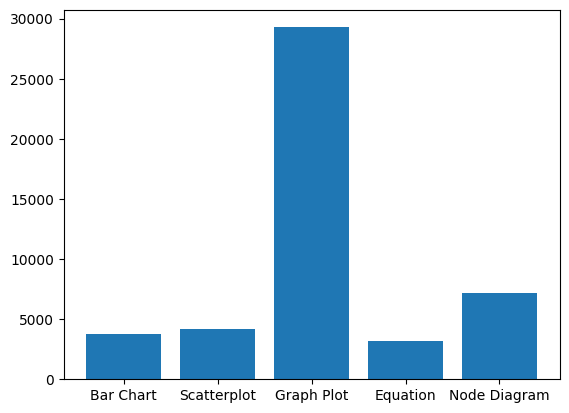

In [9]:
train_dataset = ds["train"] 
figure_type = list(set(train_dataset["figure_type"]))
dict_fig_type = dict()
for fig_type in figure_type:
    dict_fig_type[fig_type] = 0
for elt in train_dataset["figure_type"]:
    dict_fig_type[elt] += 1

# On affiche un barplot pour voir la répartition
plt.bar(range(len(dict_fig_type)), list(dict_fig_type.values()), align='center')
plt.xticks(range(len(dict_fig_type)), list(dict_fig_type.keys()))
plt.show()

In [10]:
print(dict_fig_type)

{'Bar Chart': 3795, 'Scatterplot': 4161, 'Graph Plot': 29276, 'Equation': 3192, 'Node Diagram': 7215}


On remarque que les 'Graph Plots' sont largement sur-représentés.

In [11]:
# stats(data['paragraph'])
for i in range(10):
    print(len(list(data['paragraph'])[i]))


1441
957
2543
739
1321
1356
2690
631
1171
1179


### informations

Pour chaque observation, nous disposons de différentes caractéristiques :

id <br>
figure_type <br>
ocr <br>
paragraph <br>
mention <br>
figure_description <br>
figure_description <br>
mlbcap_long <br>
mlbcap_short <br>
categories <br>

Il s'agit de chaines de caractères, on peut s'intéresser au nombre de mots qu'elles contiennent.

In [12]:
liste_sentence = []
liste_mlbcap_short = []
liste_mlbcap_long = []
liste_figure_description = []

for i in range(500): # sinon beaucoup trop long
    paragraph = list(data['paragraph'])[i][2:-2]
    mlbcap_long = list(data['mlbcap_long'])[i][2:-2]
    mlbcap_short = list(data['mlbcap_short'])[i][2:-2]
    # figure_description = list(data['figure_description'])[i][2:-2] NoneTypes issues
    paragraph_splited = re.findall(r'\w+', paragraph.lower())
    mlbcap_long_splited = re.findall(r'\w+', mlbcap_long.lower())
    mlbcap_short_splited = re.findall(r'\w+', mlbcap_short.lower())
    figure_description_splited = re.findall(r'\w+', mlbcap_short.lower())

    # sentence_splited = sentence.split()
    liste_sentence.append(len(paragraph_splited))
    liste_mlbcap_long.append(len(mlbcap_long_splited))
    liste_mlbcap_short.append(len(mlbcap_short_splited))
    # liste_figure_description.append(len(figure_description_splited))
    if i % 50 == 0:
        print(100*i/500)

    

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


KeyboardInterrupt: 

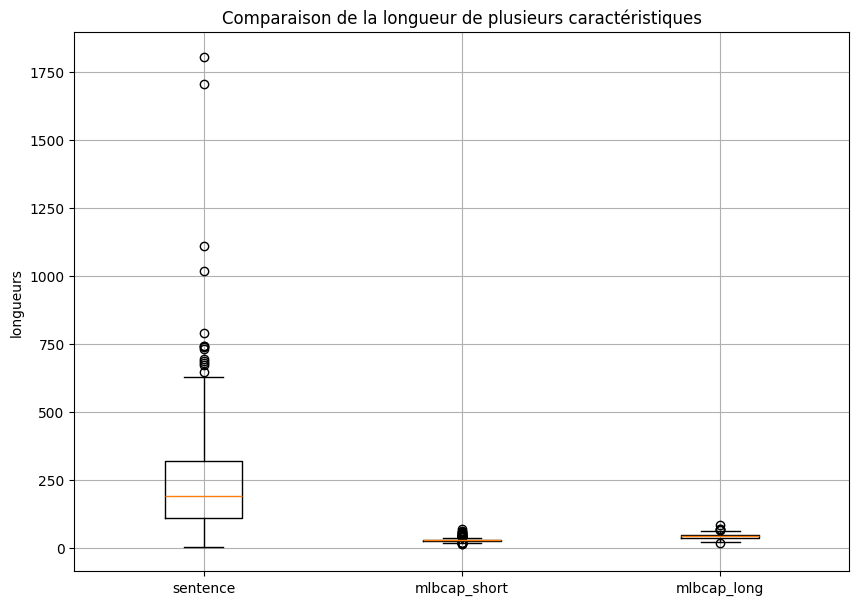

In [ ]:
boxplots = [liste_sentence, 
            # liste_figure_description, 
            liste_mlbcap_short, 
            liste_mlbcap_long]

fig = plt.figure(figsize=(10, 7))

# Création des boxplots côte à côte
plt.boxplot(boxplots)

# Optionnel : noms des catégories en x
plt.xticks([1, 2, 3], ['sentence',
                        # 'figure_description',
                        'mlbcap_short', 
                        'mlbcap_long'])

plt.title("Comparaison de la longueur de plusieurs caractéristiques")
plt.ylabel("longueurs")
plt.grid(True)
plt.show()

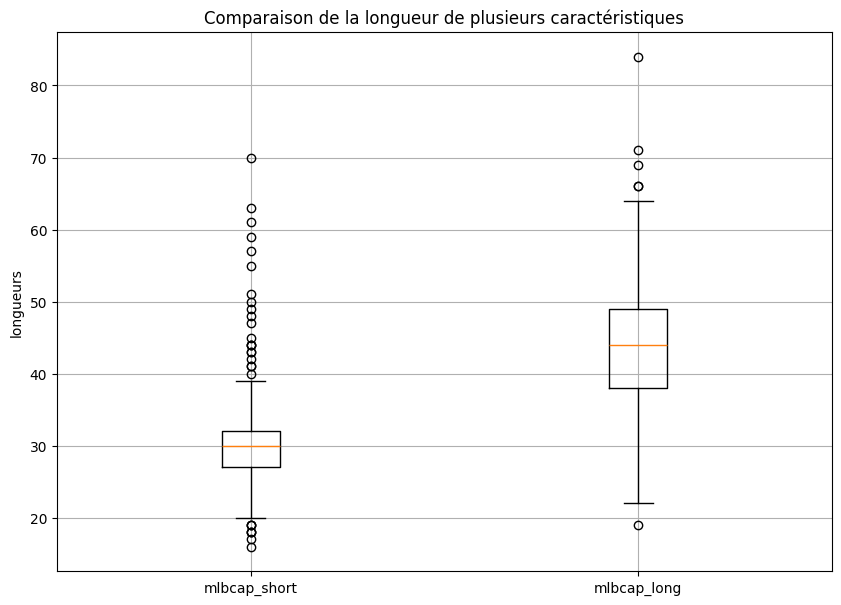

In [ ]:
boxplots = [liste_mlbcap_short, liste_mlbcap_long]

fig = plt.figure(figsize=(10, 7))

# Création des boxplots côte à côte
plt.boxplot(boxplots)

# Optionnel : noms des catégories en x
plt.xticks([1, 2], ['mlbcap_short', 'mlbcap_long'])

plt.title("Comparaison de la longueur de plusieurs caractéristiques")
plt.ylabel("longueurs")
plt.grid(True)
plt.show()

Il ne semble pas pertinent d'utiliser 'description' qui semble bien trop long, il vaut mieux idéalement utiliser 'mlbcap_short'.

## CNN pour classifier les images

### Préparations

In [4]:
# Si ton dataset est déjà chargé :
dataset = data  

# Encoder les catégories en entiers
label_encoder = LabelEncoder()
figure_types = ['Bar Chart', 'Equation', 'Graph Plot', 'Node Diagram', 'Scatterplot']
label_encoder.fit(figure_types) 
dataset = dataset.map(lambda x: {'label': label_encoder.transform([x['figure_type']])[0]})


In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]  # type: PIL.Image
        label = item["label"]
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # ajuster si RGB
])

# Split train/test
dataset = dataset.train_test_split(test_size=0.1)
train_dataset = CustomImageDataset(dataset['train'], transform=transform)
test_dataset = CustomImageDataset(dataset['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


### Construction du modèle

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [16]:
no_new_model = True
if no_new_model:
    model = SimpleCNN(num_classes=len(label_encoder.classes_))
    model.load_state_dict(torch.load("mon_modele.pth"))
    model.eval()
    print("on conserve l'ancien modèle")

else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(num_classes=len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    new_model = False
    print("on construit un nouveau modèle")
    for epoch in range(10):  # ou plus
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")
    


on conserve l'ancien modèle


### Evaluation du modèle

In [17]:
model.eval()  # Mode évaluation
correct = 0
total = 0
with torch.no_grad():  # Pas de calcul de gradients
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 98.53%


In [18]:
test_iter = iter(test_loader)
inputs1, labels1 = next(test_iter)  


with torch.no_grad():
    outputs = model(inputs1)
    _, predicted = torch.max(outputs, 1)

failed = 0
for i in range(32):
    if predicted[i].item() != labels1[i].item():
        failed +=1
print(failed)
    # print(f"Exemple {i+1}: Prédit = {predicted[i].item()}, Vrai = {labels2[i].item()}, {predicted[i].item() == labels2[i].item()}")


0


Si on souhaite conserver le modèle que l'on vient de créer :

In [15]:
# Sauvegarde du modèle
to_save = False
if to_save:
    torch.save(model.state_dict(), "mon_modele.pth")

## Réponses à des questions

### Analyse des images

In [64]:
a = ['Graph Plot']*len(dataset["train"])
idx_graph_plot = [dataset["train"]["figure_type"][i] == a[i] for i in range(10)]

print(idx_graph_plot)

[True, False, True, False, True, True, True, False, False, True]


In [ ]:
for i in range(len(idx_graph_plot)):
    if idx_graph_plot[i]:
        print(i)

0
2
4
5
6
9


In [83]:
idx = 9
image = dataset['train'][idx]['image']
for key, value in dataset['train'][idx].items():
    print(f'{key}: {value}')
image.show()

image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=571x439 at 0x1B6B782C650>
id: 511162567
figure_type: Graph Plot
ocr: ["~WS", "~W", "3 I0", "=W", "=WL", "Tal{:"]
paragraph: ["which is the same nonlinearity considered by Szalai et al. [34]. The integral-equation-based steadystate response curves are shown in Figure 2 for a full frequency sweep and for different forcing amplitudes. As expected, our Picard iteration scheme (red) converges fast for all frequencies in case of low forcing amplitudes. For higher forcing amplitude, the method no longer converges in a growing neighborhood of the resonance. To improve the results close to the resonance, we employ the Newton-Raphson scheme of Section 3.2. We see that the latter iteration captures the periodic response even for larger amplitudes near resonances until a fold arises in the response curve. We need more sophisticated continuation algorithms to capture the response around such folds. to capture the nonlinear frequency respon